# fig3E

Script started at: 2026-02-02 17:36:43


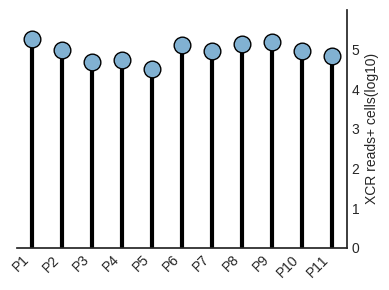

Saved: fig3D_Totalcell.pdf
Script finished at: 2026-02-02 17:37:07
Total runtime: 0:00:24.173341


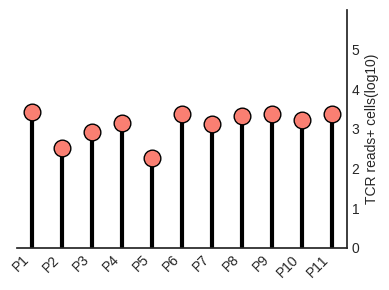

Saved: fig3D_Tcell.pdf
Script finished at: 2026-02-02 17:37:07
Total runtime: 0:00:24.308942


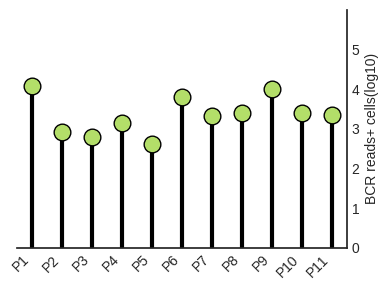

Saved: fig3D_Bcell.pdf
Script finished at: 2026-02-02 17:37:08
Total runtime: 0:00:24.443620


In [5]:
#!/usr/bin/env python3
# coding: utf-8
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import os

def main():
    # Record script start time
    start_time = datetime.now()
    print(f"Script started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # 1. Read h5ad data (please modify the path as needed)
    H5AD_PATH = '/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad'
    if not os.path.exists(H5AD_PATH):
        print(f"Warning: File {H5AD_PATH} does not exist, please modify to your own h5ad file path.")
        sys.exit(1)
    adata = sc.read_h5ad(H5AD_PATH)
    
    # 2. Sample order (can be adjusted according to experimental requirements)
    order = [
        'D06053D2', 'D06047C3', 'D06047F6', 'D06047E1', 'D06050A2',
        'D06047A2', 'D06050C2', 'D06047D4', 'D06047E2', 'D06050D4',
        'D06050E4'
    ]
    
    # 3. Batch-statistics of total cells, TCR reads+, BCR reads+
    rows = []
    for batch in order:
        data = adata[adata.obs['batch'] == batch]
        all_cell = data.obs.shape[0]
        T_cell = data.obs[
            (data.obs['TRAcdr3aa'].notna()) | (data.obs['TRBcdr3aa'].notna())
        ].shape[0]
        B_cell = data.obs[
            (data.obs['IGHcdr3aa'].notna()) | (data.obs['IGK/Lcdr3aa'].notna())
        ].shape[0]
        rows.append({
            'batch': batch,
            'all_cell': all_cell,
            'T_cell': T_cell,
            'B_cell': B_cell
        })
    df_counts = pd.DataFrame(rows)
    
    # 4. Log transformation; to avoid log(0), you can +1 (should not be needed)
    df_counts[['all_cell', 'T_cell', 'B_cell']] = df_counts[['all_cell', 'T_cell', 'B_cell']].apply(np.log10)
    
    # 5. Sort into categorical order
    df_counts['batch'] = pd.Categorical(df_counts['batch'], categories=order, ordered=True)
    df_counts = df_counts.sort_values('batch').reset_index(drop=True)
    
    # 6. Configure three kinds of plots and outputs
    plot_configs = [
        {
            "y_col": "all_cell",
            "color": "#81B1D2",
            "pdf_name": "fig3D_Totalcell.pdf",
            #"title": "Number of XCR+ cells",
            "ylabel": "XCR reads+ cells(log10)"
        },
        {
            "y_col": "T_cell",
            "color": "#FA7F72",
            "pdf_name": "fig3D_Tcell.pdf",
            #"title": "Number of TCR reads+ cells",
            "ylabel": "TCR reads+ cells(log10)"
        },
        {
            "y_col": "B_cell",
            "color": "#B3DE69",
            "pdf_name": "fig3D_Bcell.pdf",
            #"title": "Number of BCR reads+ cells",
            "ylabel": "BCR reads+ cells(log10)"
        },
    ]
    
    # 7. Loop plotting
    xtick_labels = [f'P{i}' for i in range(1, len(order)+1)]  # P1 to P11
    for cfg in plot_configs:
        y_col = cfg["y_col"]
        df_plot = df_counts.reset_index(drop=True)
        x_pos = range(df_plot.shape[0])
    
        fig, ax = plt.subplots(figsize=(4, 3))
        markerline, stemline, baseline = ax.stem(
            x_pos,
            df_plot[y_col],
            linefmt='k-',
            markerfmt='o',
            basefmt=' '
        )
        stemline.set_linewidth(3)
        markerline.set_markersize(12)
        markerline.set_markerfacecolor(cfg["color"])
        markerline.set_markeredgewidth(1)
        # Move y-axis to the right
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        # Move baseline x to the right end
        baseline.set_xdata([ax.get_xlim()[1]] * 2)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(xtick_labels, rotation=45, ha='right')  # Modified here
        ax.set_ylabel(cfg["ylabel"])
        ax.set_title(cfg.get("title", ""))
        ax.set_ylim(0, 6)
        ax.set_yticks([0, 1, 2, 3, 4, 5])
        sns.despine(ax=ax, left=True, right=False)
        plt.tight_layout()
        plt.grid(False)
        plt.savefig(cfg["pdf_name"])
        plt.show() # Safer release
        print(f"Saved: {cfg['pdf_name']}")
        
        # 8. Print elapsed time
        end_time = datetime.now()
        print(f"Script finished at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print("Total runtime:", end_time - start_time)

if __name__ == "__main__":
    main()

# fig3F

/tmp/ipykernel_248629/2123113818.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=4)


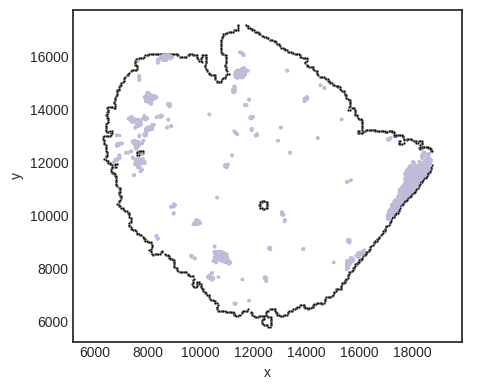

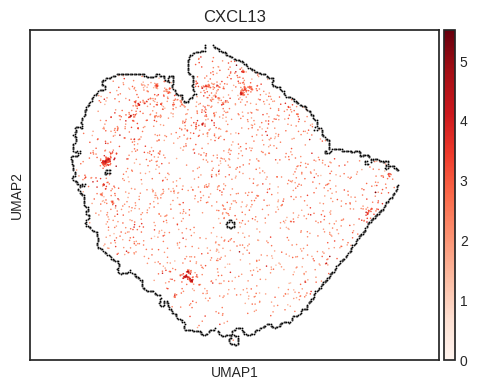

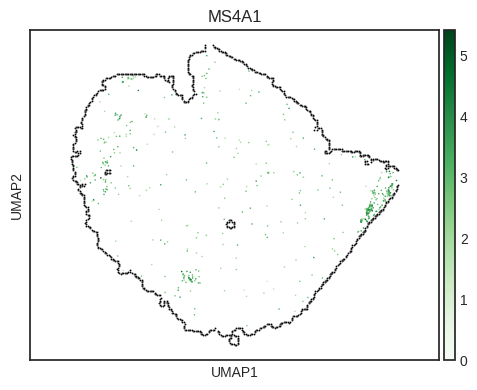

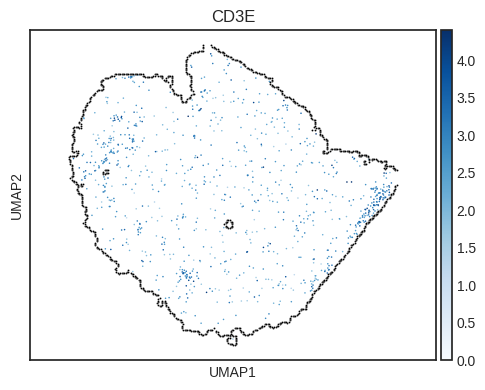

All plots have been saved.


In [4]:
import os
import sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def load_adata(h5ad_path):
    """Load AnnData object from h5ad file."""
    return sc.read_h5ad(h5ad_path)

def plot_overview_figure(adata, outfile='Figure3F_overview.png'):
    """Plot tissue overview and LA-TLS scatter plot."""
    tissue_outline = pd.DataFrame(adata.uns['tissue_outline'], columns=['x', 'y'])
    adata.uns['bin50 structural annotation_colors'] = [
        '#8dd3c7', '#feffb3', '#bfbbd9', '#fa8174', '#81b1d2', 'white', '#b3de69'
    ]
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    df = adata.obs
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=tissue_outline, x='x', y='y', color='black', s=3)
    sns.scatterplot(
        data=df[df['bin50 structural annotation']=='LA-TLS'],
        x='x', y='y', color='#bfbbd9', edgecolor='none', s=4
    )
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=4)
    plt.grid(False)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(outfile, dpi=600, bbox_inches='tight')
    plt.show()

def custom_cmap(base_cmap, color_name):
    """
    Create a colormap whose lowest value (0) is white, supports matplotlib colormaps.
    """
    colors = base_cmap(np.linspace(0, 1, 256))
    colors[0] = [1, 1, 1, 1]  # Set lowest value to white (RGBA)
    return LinearSegmentedColormap.from_list(f'custom_{color_name}', colors)

def plot_umap_marker(adata, gene, outline_df, cmap, outfile):
    """Plot UMAP spatial scatter for given marker and overlay tissue outline."""
    fig, ax = plt.subplots(figsize=(5, 4))
    sc.pl.umap(adata, color=[gene], cmap=cmap, s=5, ax=ax, show=False)
    sns.scatterplot(data=outline_df, x='x', y='y', color='black', s=2, ax=ax, legend=None)
    plt.tight_layout()
    plt.axis('equal')
    plt.savefig(outfile, dpi=2500, bbox_inches='tight')
    plt.show()

def main():
    # === Modify the path below to your own AnnData file ===
    h5ad_path = '/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad'
    adata = load_adata(h5ad_path)
    # Prepare tissue outline dataframe
    tissue_outline = pd.DataFrame(adata.uns['tissue_outline'], columns=['x', 'y'])
    # Overview Annotation Plot
    plot_overview_figure(adata, outfile='fig3F_overview.png')
    # Marker color maps
    cmap_CXCL13 = custom_cmap(plt.cm.Reds, 'reds')
    cmap_MS4A1 = custom_cmap(plt.cm.Greens, 'greens')
    cmap_CD3E = custom_cmap(plt.cm.Blues, 'blues')
    # Marker Spatial Plots
    plot_umap_marker(adata, "CXCL13", tissue_outline, cmap_CXCL13, "CXCL13_zoomin.png")
    plot_umap_marker(adata, "MS4A1", tissue_outline, cmap_MS4A1, "MS4A1_zoomin.png")
    plot_umap_marker(adata, "CD3E", tissue_outline, cmap_CD3E, "CD3E_zoomin.png")
    print("All plots have been saved.")

if __name__ == "__main__":
    main()

# fig3G

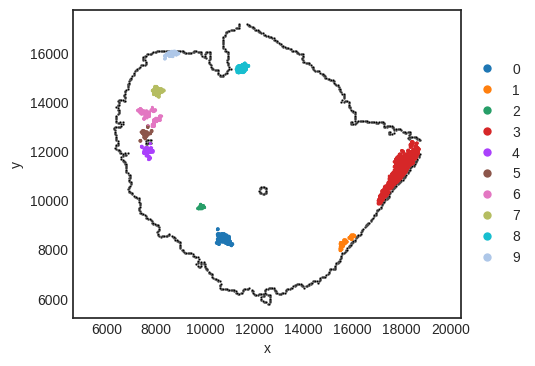

In [3]:
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')
df = adata.obs
tissue_outline1 = pd.DataFrame(adata.uns['tissue_outline'], columns=['x', 'y'])

plt.figure(figsize=(5, 4))
plt.style.use('seaborn-v0_8-white')

# Tissue outline as background
sns.scatterplot(data=tissue_outline1, x='x', y='y', color='black', s=3)

# Scatterplot for TLS clusters (if present)
sns.scatterplot(
    data=df[df['TLScluster'].notna()],
    x='x', y='y', hue='TLScluster',
    palette=['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
             '#e377c2', '#b5bd61', '#17becf', '#aec7e8'],
    edgecolor='none', s=4
)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=3)
plt.grid(False)
plt.axis('equal')
plt.savefig('fig3G.pdf', dpi=600, bbox_inches='tight')

# fig3I

/tmp/ipykernel_248629/832789138.py:24: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata1.concatenate(adata_list[1:], batch_key="batch", batch_categories=batch_categories)
/home/fengyu/miniconda3/envs/omicverse/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/tmp/ipykernel_248629/832789138.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(isotype_col)[cluster_col]
/tmp/ipykernel_248629/832789138.py:64: FutureWarning: The default of observed=False is deprecated and will be changed

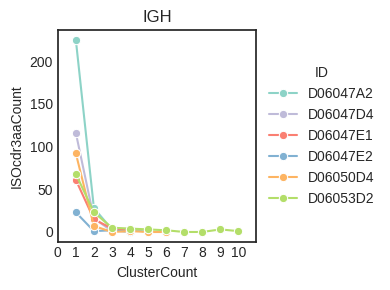

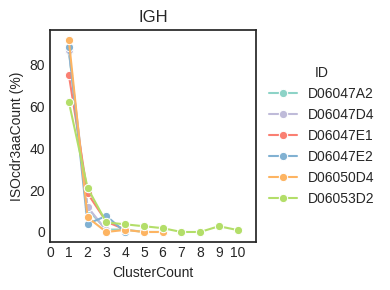

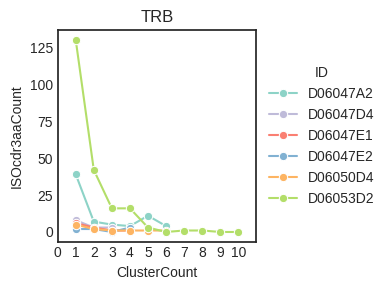

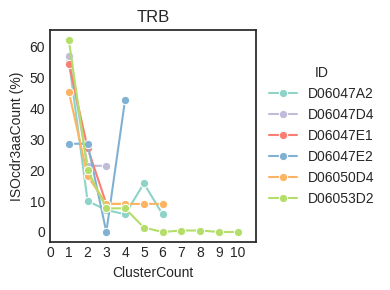

All CDR3 diversity plots have been saved.


In [7]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn white theme
plt.style.use('seaborn-v0_8-white')

# 1. Load each sample's AnnData object one by one
adata1 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2.h5ad')
adata3 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047D4/test_analysis_celltype/D06047D4.h5ad')
adata4 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047E1/test_analysis_celltype/D06047E1.h5ad')
adata5 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047E2/test_analysis_celltype/D06047E2.h5ad')
adata9 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06050D4/test_analysis_celltype/D06050D4.h5ad')
adata11 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/D06053D2.h5ad')

adata_list = [adata1, adata3, adata4, adata5, adata9, adata11]
for adata in adata_list:
    adata.var_names_make_unique()  # Make sure gene names are unique to avoid errors on merge

# 2. Merge all samples into one AnnData object and add batch annotation
batch_categories = ["D06047A2", "D06047D4", "D06047E1", "D06047E2", "D06050D4", "D06053D2"]
adata = adata1.concatenate(adata_list[1:], batch_key="batch", batch_categories=batch_categories)

# --- Analyze IGHcdr3aa diversity ---
def get_tls_cdr3_summary(adata, groupby_cdr3_col, batch_key='batch', tls_col='TLScluster'):
    """
    Count for each sample how many unique TLSclusters each CDR3/BCR/TCR appears in, 
    and summarize distribution of ClusterCount.
    :param adata: merged AnnData object
    :param groupby_cdr3_col: e.g., 'IGHcdr3aa' or 'TRBcdr3aa'
    :param batch_key: batch grouping column
    :param tls_col: TLS cluster annotation column
    :return: summary DataFrame
    """
    tmp = pd.DataFrame(columns=['ClusterCount', 'ISOcdr3aaCount', 'id'])
    for i in adata.obs[batch_key].unique():
        m = adata[adata.obs[batch_key] == i]
        data = m.obs
        cluster_col = 'cluster'
        isotype_col = groupby_cdr3_col

        # 1) Count actual TLSclusters in this sample
        actual_clusters = data[tls_col].dropna().unique()
        n_tls = len(actual_clusters)

        # 2) Prepare summary table
        df = data[[tls_col, isotype_col]].copy()
        df[cluster_col] = 'x'
        df.loc[df[tls_col].notna(), cluster_col] = df[tls_col]
        df = df[df[cluster_col] != 'x']     # keep only rows with a TLS cluster
        df = df[df[isotype_col].notna()]    # keep only rows with CDR3 annotation

        # 3) If no TLS/BCR in sample, summary is all zeros
        if df.empty:
            count_summary = pd.DataFrame({
                'ClusterCount': range(1, n_tls + 1),
                'ISOcdr3aaCount': 0
            })
        else:
            # For each iso/CDR3, in how many distinct TLSclusters does it occur
            cluster_counts = (
                df.groupby(isotype_col)[cluster_col]
                  .nunique()
                  .reset_index(name='ClusterCount')
            )
            # Count summary: for each x TLSclusters, how many iso/CDR3 have this number
            count_summary = (
                cluster_counts['ClusterCount']
                .value_counts()
                .sort_index()
                .reset_index()
                .rename(columns={'index': 'ClusterCount', 'count': 'ISOcdr3aaCount'})
            )
            # Fill out ClusterCount range for missing values
            full_range = pd.RangeIndex(1, n_tls + 1, name='ClusterCount')
            count_summary = (
                count_summary
                .set_index('ClusterCount')
                .reindex(full_range, fill_value=0)
                .reset_index()
            )

        # 4) Add sample id
        count_summary['id'] = i
        # 5) Append to overall table
        tmp = pd.concat([tmp, count_summary], axis=0, ignore_index=True)

    tmp = tmp.astype({'ClusterCount': int, 'ISOcdr3aaCount': int})
    return tmp

# Compute IGHcdr3aa diversity
igh_tmp = get_tls_cdr3_summary(adata, groupby_cdr3_col='IGHcdr3aa', batch_key='batch')
trb_tmp = get_tls_cdr3_summary(adata, groupby_cdr3_col='TRBcdr3aa', batch_key='batch')

# Plotting parameters
colos = ['D06047A2','D06047D4','D06047E1','D06047E2','D06050D4','D06053D2']
palette_colors = ['#8DD3C7','#BFBBD9','#FA7F72','#81B1D2','#FDB462','#B3DE69']

# --- Plot IGH linecharts (raw counts and percent) ---
df_igh = igh_tmp[igh_tmp['id'].isin(colos)]
# Absolute count line plot
plt.figure(figsize=(4, 3))
sns.lineplot(data=df_igh, x='ClusterCount', y='ISOcdr3aaCount', 
             palette=palette_colors, hue='id', marker='o')
plt.title('IGH')
plt.legend(title='ID', loc="center left", bbox_to_anchor=(1, 0.5), markerscale=1)
plt.grid(False)
plt.xlim(0 , 11)
plt.xticks(range(0, 11))
plt.tight_layout()
plt.savefig('./fig3I_upper_left_IGH.pdf', dpi=600, bbox_inches='tight')
plt.show()

# Percentage line plot
plt.figure(figsize=(4, 3))
group_sums = df_igh.groupby('id')['ISOcdr3aaCount'].transform('sum')
df_igh['ISOcdr3aaCount_pct'] = (df_igh['ISOcdr3aaCount'] / group_sums) * 100
sns.lineplot(data=df_igh, x='ClusterCount', y='ISOcdr3aaCount_pct', 
             palette=palette_colors, hue='id', marker='o')
plt.title('IGH')
plt.xlabel('ClusterCount')
plt.ylabel('ISOcdr3aaCount (%)')
plt.legend(title='ID', loc="center left", bbox_to_anchor=(1, 0.5), markerscale=1)
plt.xlim(0, 11)
plt.xticks(range(0, 11))
plt.tight_layout()
plt.savefig('./fig3I_lower_left_IGH.pdf', dpi=600, bbox_inches='tight')
plt.show()

# --- Plot TRB linecharts (raw counts and percent) ---
df_trb = trb_tmp[trb_tmp['id'].isin(colos)]
# Absolute count line plot
plt.figure(figsize=(4, 3))
sns.lineplot(data=df_trb, x='ClusterCount', y='ISOcdr3aaCount', 
             palette=palette_colors, hue='id', marker='o')
plt.title('TRB')
plt.legend(title='ID', loc="center left", bbox_to_anchor=(1, 0.5), markerscale=1)
plt.grid(False)
plt.xlim(0 , 11)
plt.xticks(range(0, 11))
plt.tight_layout()
plt.savefig('./fig3I_upper_right_TRB.pdf', dpi=600, bbox_inches='tight')
plt.show()

# Percentage line plot
plt.figure(figsize=(4, 3))
group_sums = df_trb.groupby('id')['ISOcdr3aaCount'].transform('sum')
df_trb['ISOcdr3aaCount_pct'] = (df_trb['ISOcdr3aaCount'] / group_sums) * 100
sns.lineplot(data=df_trb, x='ClusterCount', y='ISOcdr3aaCount_pct', 
             palette=palette_colors, hue='id', marker='o')
plt.title('TRB')
plt.xlabel('ClusterCount')
plt.ylabel('ISOcdr3aaCount (%)')
plt.legend(title='ID', loc="center left", bbox_to_anchor=(1, 0.5), markerscale=1)
plt.xlim(0, 11)
plt.xticks(range(0, 11))
plt.tight_layout()
plt.savefig('./fig3I_lower_right_TRB.pdf', dpi=600, bbox_inches='tight')
plt.show()

print("All CDR3 diversity plots have been saved.")

# fig3K

/tmp/ipykernel_1590036/162112636.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['anno'] = tmp['anno'].astype(str)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0


/tmp/ipykernel_1590036/162112636.py:71: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


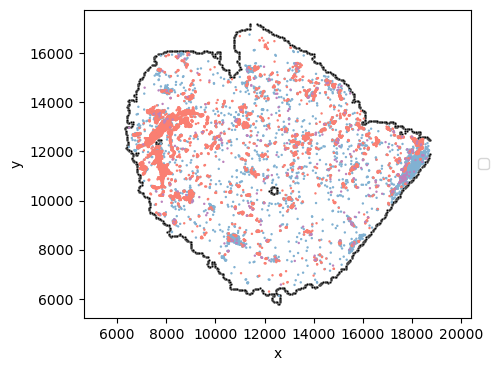

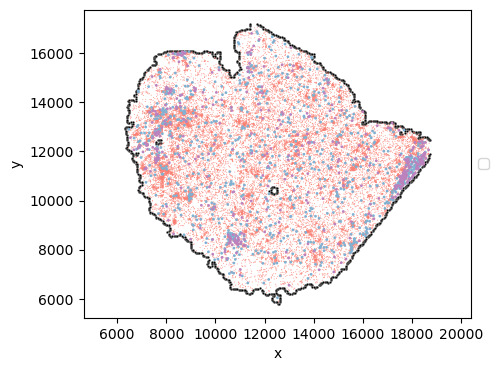

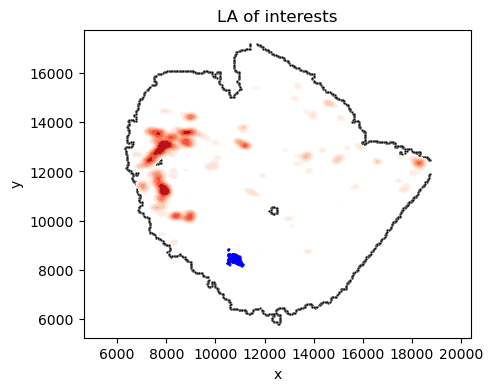

1


/tmp/ipykernel_1590036/162112636.py:71: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


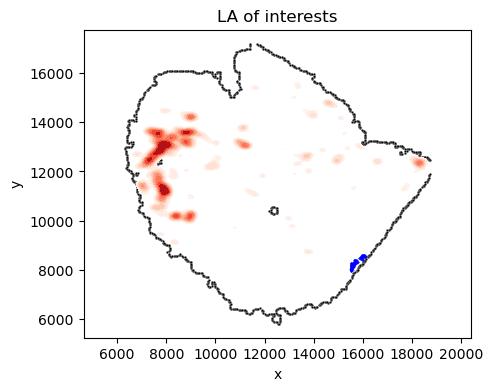

2


/tmp/ipykernel_1590036/162112636.py:71: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


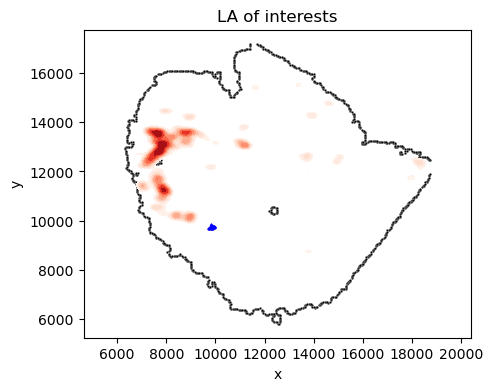

3


/tmp/ipykernel_1590036/162112636.py:71: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


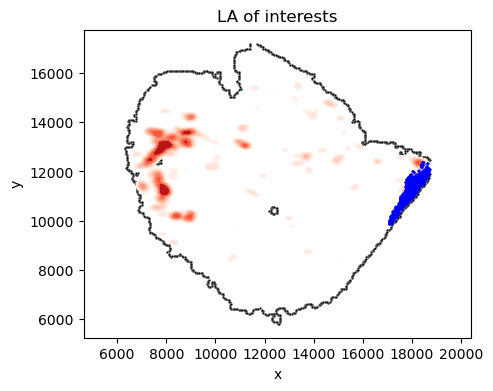

4


/tmp/ipykernel_1590036/162112636.py:71: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


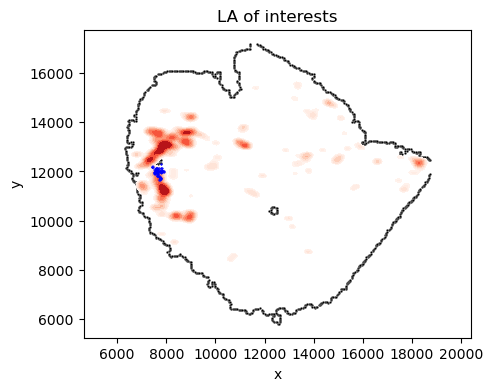

5


/tmp/ipykernel_1590036/162112636.py:71: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


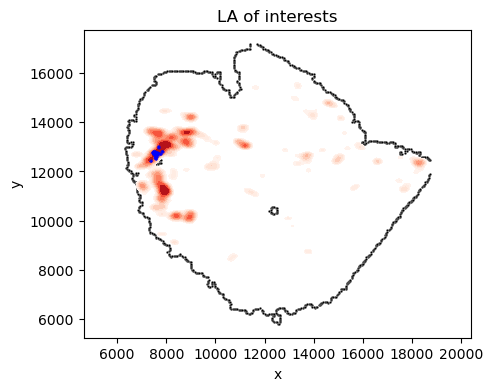

6


/tmp/ipykernel_1590036/162112636.py:71: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


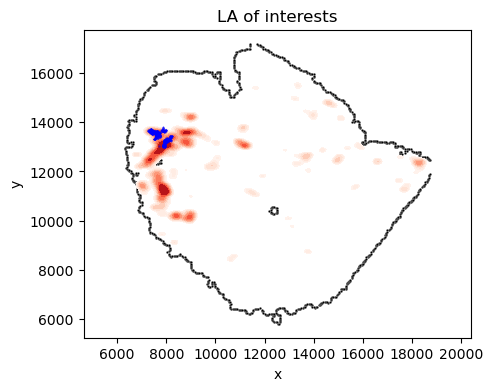

7


/tmp/ipykernel_1590036/162112636.py:71: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


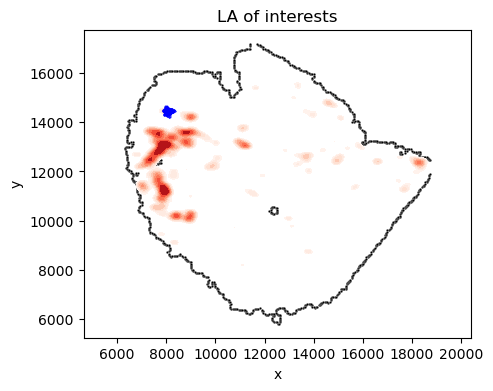

8


/tmp/ipykernel_1590036/162112636.py:71: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


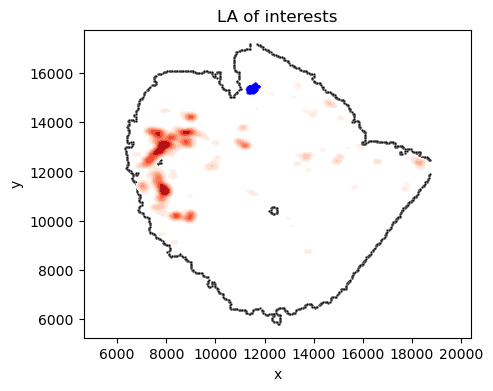

9


/tmp/ipykernel_1590036/162112636.py:71: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


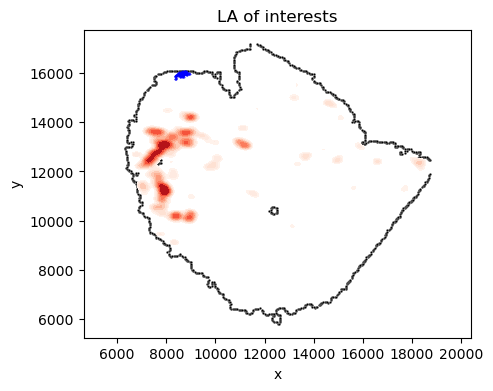

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


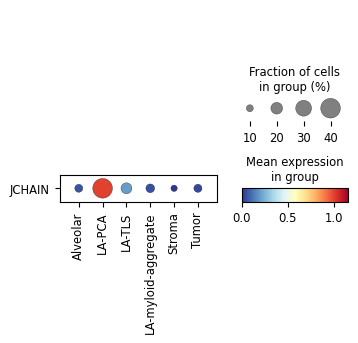

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.neighbors import NearestNeighbors
from libpysal.weights import KNN as W_KNN

# ----------- Figure 3K Left: Spatial annotation plot by cell type -----------
adata9 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')
df = adata9.obs
tissue_outline = pd.DataFrame(adata9.uns['tissue_outline'], columns=['x', 'y'])
plt.figure(figsize=(5, 4))

# Plot tissue outline as background
sns.scatterplot(data=tissue_outline, x='x', y='y', color='black', s=3)

# Plot selected cell types
tmp = df[df['anno'].isin(['plasma_cell', 'Tcell', 'b_cell'])]
tmp['anno'] = tmp['anno'].astype(str)
sns.scatterplot(data=tmp[tmp['anno'] == 'Tcell'], x='x', y='y', color='#81B1D2', edgecolor='none', s=3)
sns.scatterplot(data=tmp[tmp['anno'] == 'plasma_cell'], x='x', y='y', color='#FA7F72', edgecolor='none', s=3)
sns.scatterplot(data=tmp[tmp['anno'] == 'b_cell'], x='x', y='y', color='#BC82BD', edgecolor='none', s=3)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=10)
plt.grid(False)
plt.axis('equal')
plt.savefig('./fig3K_left.png', dpi=1200, bbox_inches='tight')

# ----------- Figure 3K Right: Marker gene spatial plot -----------
df = adata9[:, ['JCHAIN', 'CD3E', 'MS4A1']].to_df()
df = adata9.obs.merge(df, left_index=True, right_index=True)

tissue_outline = pd.DataFrame(adata9.uns['tissue_outline'], columns=['x', 'y'])
plt.figure(figsize=(5, 4))
sns.scatterplot(data=tissue_outline, x='x', y='y', color='black', s=3)
sns.scatterplot(data=df[df['JCHAIN'] != 0], x='x', y='y', color='#FA7F72', edgecolor='none', s=0.4)
sns.scatterplot(data=df[df['CD3E'] != 0], x='x', y='y', color='#81B1D2', edgecolor='none', s=4)
sns.scatterplot(data=df[df['MS4A1'] != 0], x='x', y='y', color='#BC82BD', edgecolor='none', s=4)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=10)
plt.grid(False)
plt.axis('equal')
plt.savefig('./fig3K_right.png', dpi=1200, bbox_inches='tight')

# ----------- Figure 3H: Density plot for shared IGHcdr3aa sequence distribution per TLS cluster -----------
for i in adata9.obs['TLScluster'].cat.categories.to_list():
    LA = 'LA-TLS'
    clus = 'TLScluster'
    iso = 'IGHcdr3aa'
    clusNo = i
    tissue_outline = pd.DataFrame(adata9.uns['tissue_outline'], columns=['x', 'y'])
    print(i)
    df = adata9.obs
    df = df[df['bin50 structural annotation'] == LA]
    crosstab = pd.crosstab(df[clus], df[iso])
    shared_sequences = crosstab.columns[crosstab.sum(axis=0) > 1]
    shared_stats = crosstab.sum(axis=0)
    num_shared_sequences = len(shared_sequences)
    shared_details = shared_stats[shared_sequences]
    shared_stats.value_counts()
    
    TLS_XCR = [x for x in df[df[clus] == clusNo][iso].unique().to_list() if not pd.isna(x)]
    df2 = adata9.obs
    
    plt.figure(figsize=(5, 4))
    # Plot tissue outline background
    sns.scatterplot(data=tissue_outline, x='x', y='y', color='black', s=3)
    # Plot KDE for shared IGHcdr3aa sequences
    plt.grid(False)
    plt.title('LA of interests')
    sns.kdeplot(
        data=df2[df2[iso].isin(TLS_XCR)],
        x='x', y='y',
        fill=True, cmap='Reds', bw_adjust=0.2,
        thresh=0.5, kernel='linear', cut=0.2
    )
    # Plot member spots for the current TLS cluster
    plt.scatter(df2[df2[clus].isin([clusNo])]['x'],
                df2[df2[clus].isin([clusNo])]['y'],
                color='blue', s=0.1)
    plt.axis('equal')
    plt.savefig(f'./fig3K_D06053D2_IGH_TLS_{i}.png', dpi=1200, bbox_inches='tight')
    plt.show()

# ----------- Figure 3K Dotplot for marker genes per annotation -----------
sc.pp.normalize_total(adata9, target_sum=1e4)
sc.pp.log1p(adata9)
marker_genes = ['JCHAIN']
sc.pl.dotplot(
    adata9,
    marker_genes,
    groupby='bin50 structural annotation',
    cmap='RdYlBu_r',
    standard_scale='var',
    vmax=1.15, swap_axes=True, dot_max=0.4,
    # categories_order=['PCA_IGHM', 'PCA_IGHG/A'],
    save='fig3K_dotplot.pdf'
)